# Notebook 1 - Education and Salary - a first overview in California.

This notebook aims to create a single dataframe collecting data from the _Census.Gov_ and the _Bureau of Economic Analysis_ page with information on:
1. Education Levels - Namely the percentage of Over25 that hold a Bachelor's degree
2. Education Institution Presence - from the Firms API we analysed the "educational services" category (number 61) that showed us per each county how many educ. centres were present (this includes kindergarten, schools of any level and university)
3. Salary - The total income of the county [Source: US Bureau of Economic Analysis]

**PLEASE NOTE** In this notebook we started testing the API and the possibility of a single dataframe. For this notebook only, the data will be taken from the state of California, while in the next steps we extend our research to the remaining states.


We start by importing the necessary libraries, retrieving the data from the API and analysing only the state of California for the sake of notebook size, we will proceed to a further analysis in a later step of our project

In [1]:
#Required imports for the project
import requests # for api requests
import pandas as pd #tabular data

from bs4 import BeautifulSoup

API Query.

In [84]:
# !! REMINDER TO TAKE API KEY OUT OF CODE BEFORE SUBMITTING !!
api_key = ""

In [85]:
#creating a dataframe function
def json_to_dataframe(response):
    return pd.DataFrame(response.json()[1:], columns=response.json()[0])

In [86]:
#Creating a function to remove the leading zeros from a column
def remove_leading_zeros(df, column):
    df[column] = df[column].str.lstrip('0')
    return df

In [87]:
#Setting up the API Query parameters for the educational services industry
params1 = {"NAICS2017" : 61}

In [88]:
#Requesting the json file from the census website using the api key
url = "https://api.census.gov/data/2017/ecnbasic?get=NAICS2017_LABEL,NAICS2017,GEO_ID,FIRM&for=county:*&key={}".format(api_key)
response = requests.request("GET", url, params=params1)

In [89]:
response.text[0:77]

'[["NAICS2017_LABEL","NAICS2017","GEO_ID","FIRM","NAICS2017","state","county"]'

In [90]:
#Converting ecn data frame into pandas data frame
educational_services = json_to_dataframe(response)
df = pd.DataFrame(data = educational_services)
df['FIRM'] = df['FIRM'].astype(int)
df['state'] = df['state'].astype("string")
df_california1 = df[df['state'] == '06']

In [91]:
# Top 5 counties with largest number of educational services
df_c_sort = df_california1\
.sort_values(by=['FIRM'], ascending=False)\
.head(10)
print('Top 10 counties with the most amount of educational services in California')
df_c_sort

Top 10 counties with the most amount of educational services in California


,NAICS2017_LABEL,NAICS2017,GEO_ID,FIRM,NAICS2017,state,county
300,Educational services,61,0500000US06037,2787,61,06,037
316,Educational services,61,0500000US06059,1187,61,06,059
331,Educational services,61,0500000US06073,1010,61,06,073
303,Educational services,61,0500000US06085,822,61,06,085
211,Educational services,61,0500000US06001,693,61,06,001
216,Educational services,61,0500000US06075,470,61,06,075
212,Educational services,61,0500000US06067,334,61,06,067
320,Educational services,61,0500000US06081,323,61,06,081
301,Educational services,61,0500000US06065,313,61,06,065
202,Educational services,61,0500000US06013,295,61,06,013


In [92]:
#Number of counties in the enc dataset for California
df_california1['county'].count()

48

In [93]:
#Setting the params
params2 = {"state" : "06"}

In [94]:
#Getting the ACS data
#Requesting the json file from the census website using the api key 
url = "https://api.census.gov/data/2017/acs/acs1/profile?get=DP02_0064PE,DP02_0088PE,DP02_0123PE&for=county&key={}".format(api_key)
response2 = requests.request("GET", url)

In [95]:
#Seeing what the columns for the data are
response2.text[0:61]

'[["DP02_0064PE","DP02_0088PE","DP02_0123PE","state","county"]'

## Meaning of variables
- **DP02_0064PE** = Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree

In [96]:
pop_chars = json_to_dataframe(response2)
df = pd.DataFrame(data = pop_chars)
df_california2 = df[df['state'] == '06']

In [97]:
#Number of counties in the acs dataset for California
df_california2['county'].count()

40

In [98]:
#Merging the two datasets
merged_census = pd.merge(df_california1, df_california2, on='county')
#drop state_y column and rename state_x to state
merged_census = merged_census.drop(columns=['state_y', 'NAICS2017'])
merged_census = merged_census.rename(columns={'state_x': 'state', 'FIRM':'Number of Educational Institutions','DP02_0064PE':'Percent of Population with a Bachelor\'s Degree'})
#Convert the columns to the correct data types
merged_census['Percent of Population with a Bachelor\'s Degree'] = merged_census['Percent of Population with a Bachelor\'s Degree'].astype(float)
merged_census['county'] = merged_census['county'].astype(int)
# The last two columns are currently unneeded but will be later used for contextual analysis.
#Drop the last two columns
merged_census = merged_census.drop(columns=['DP02_0088PE', 'DP02_0123PE'])

We finally create a merged_census file containing the Number of Educational Institutions and the Percent of Population with a Bachelor's Degree.

In [99]:
merged_census.head()

,NAICS2017_LABEL,GEO_ID,Number of Educational Institutions,state,county,Percent of Population with a Bachelor's Degree
0,Educational services,0500000US06047,13,06,47,8.7
1,Educational services,0500000US06033,8,06,33,9.5
2,Educational services,0500000US06013,295,06,13,26.7
3,Educational services,0500000US06083,137,06,83,21.2
4,Educational services,0500000US06115,0,06,115,13.9


For easier reference, we attach the County Name through the State and County codes. 

In [100]:
#Merge the merged_census dataframe with the ca_counties dataframe to get the county names
merged_census = pd.merge(merged_census, ca_counties, left_on= 'county', right_on = 'County')
#Reshape the GEO_ID to get the FIPS code
merged_census['GEO_ID'] = merged_census['GEO_ID'].str[9:]

merged_census

,NAICS2017_LABEL,GEO_ID,Number of Educational Institutions,state,county,Percent of Population with a Bachelor's Degree,County,County_Name
0,Educational services,06047,13,06,47,8.7,47,Merced County
1,Educational services,06033,8,06,33,9.5,33,Lake County
2,Educational services,06013,295,06,13,26.7,13,Contra Costa County
3,Educational services,06083,137,06,83,21.2,83,Santa Barbara County
4,Educational services,06115,0,06,115,13.9,115,Yuba County
5,Educational services,06099,71,06,99,12.0,99,Stanislaus County
6,Educational services,06097,161,06,97,22.6,97,Sonoma County
7,Educational services,06025,5,06,25,10.4,25,Imperial County
8,Educational services,06001,693,06,1,26.9,1,Alameda County
9,Educational services,06067,334,06,67,20.0,67,Sacramento County


In [101]:
#Drop the columns that are not needed
#merged_census = merged_census.drop(columns=['County_Name_x', 'County_x', 'County_y', 'County'])
merged_census = merged_census.drop(columns=['state', 'county'])
merged_census = merged_census.rename(columns={'County_Name_y': 'County_Name'})

In [102]:
#Converting the columns to the right data types
merged_census['Number of Educational Institutions'] = merged_census['Number of Educational Institutions'].astype(int)
merged_census['Percent of Population with a Bachelor\'s Degree'] = merged_census['Percent of Population with a Bachelor\'s Degree'].astype(float)
merged_census['County_Name'] = merged_census['County_Name'].astype('string')

To create the graph, we have to remove some of the variables.

In [103]:
# Remove NAICS2017_LABEL, state, county, County and County_name columns
merged_census = merged_census.drop(columns=['NAICS2017_LABEL', 'County', 'County_Name'])
#Create a copy of merged_census called education_data
education_data = merged_census.copy()
merged_census.head(5)

,GEO_ID,Number of Educational Institutions,Percent of Population with a Bachelor's Degree
0,06047,13,8.7
1,06033,8,9.5
2,06013,295,26.7
3,06083,137,21.2
4,06115,0,13.9


## Getting the Code on National Income

In [104]:
import pandas as pd
#import excel file and convert to dataframe
us_gdp = pd.read_excel("../data/us_gdp_2009-18.xlsx")
# if GeoFIPS is under 10000, add a 0 in front of it
us_gdp['Clean GeoFIPS'] = us_gdp['Clean GeoFIPS'].apply(lambda x: '{0:0>5}'.format(x))
#convert GeoFIPS to string
us_gdp['Clean GeoFIPS'] = us_gdp['Clean GeoFIPS'].astype('string')
#keep only Clean GEOFIPS and GDP per Capita 2017
us_gdp = us_gdp[['Clean GeoFIPS', 'GDP per Capita 2017']]
#rename Clean GeoFIPS to GEO_ID
us_gdp = us_gdp.rename(columns={'Clean GeoFIPS': 'GEO_ID'})
us_gdp.head(5)

,GEO_ID,GDP per Capita 2017
0,01001,25.839051
1,01003,27.172905
2,01005,28.457883
3,01007,15.671346
4,01009,14.114381


In [105]:
#Merge the gdp dataframe with the education_data dataframe
merged_gdp = pd.merge(education_data, us_gdp, on='GEO_ID')
merged_gdp.head(5)

,GEO_ID,Number of Educational Institutions,Percent of Population with a Bachelor's Degree,GDP per Capita 2017
0,06047,13,8.7,35.545039
1,06033,8,9.5,32.864295
2,06013,295,26.7,67.186104
3,06083,137,21.2,60.634992
4,06115,0,13.9,39.997401


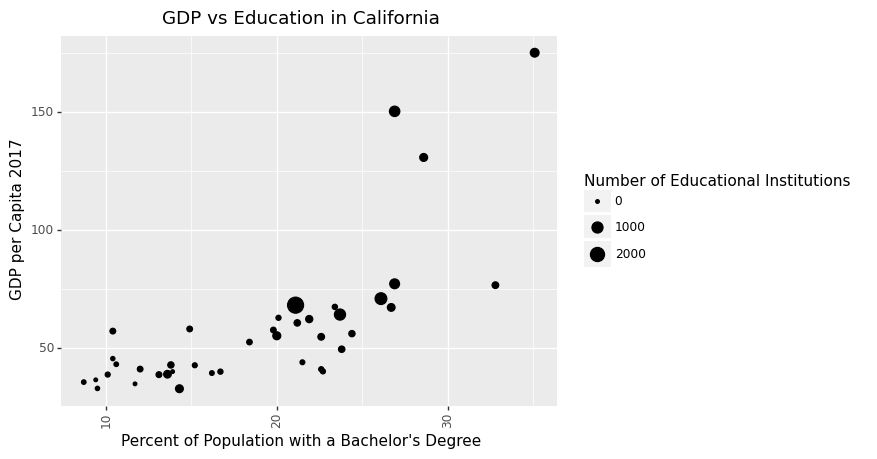

<ggplot: (8786321386530)>

In [106]:
# Create a scatterplot of the data with on the x-axis the percent of population with a Bachelor's Degree and on the y-axis the GDP per capita, the size of the bubbles is the number of educational institutions using plotnine
from plotnine import *
#Add a title to the plot
(ggplot(merged_gdp, aes(x='Percent of Population with a Bachelor\'s Degree', y='GDP per Capita 2017', size='Number of Educational Institutions')) + geom_point() + ggtitle("GDP vs Education in California") + theme(axis_text_x=element_text(angle=90)))


In [107]:
# Calculate the coefficient of correlation between the two variables
merged_gdp['Percent of Population with a Bachelor\'s Degree'].corr(merged_gdp['GDP per Capita 2017'])

0.7228024336203953

A correlation is evident here.